<a href="https://colab.research.google.com/github/ckevar/Conv4MammographyAbnormalities/blob/main/Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries and Mounting Drive
In the following notebook the ensemble system will developed for 2-class classifier, meaning, the output of the previous **2-class classifier** will be called, and they will be merged aiming to have a robust discrimination.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 
import os

import requests

from tensorflow.keras import layers

from google.colab import output
from google.colab import drive

# Mounting Drive
drive.mount("/content/gdrive")
base_path = "/content/gdrive/My Drive/CI_proj/"
metrics_path = base_path+"metrics/"

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

Mounted at /content/gdrive


#Load data
The models themselves won't be load, just the testing output that was being saved at the end of each previous task

In [ ]:
def np_load_y_true():
  labels_test = np.array([])

  labels = np.load(base_path+'dataset/public_test_labels.npy')
  for i in range(labels.shape[0]):
    if ((labels[i] == 1) or (labels[i] == 2)):    # mass
      labels_test = np.append(labels_test, [0])
    elif ((labels[i] == 3) or (labels[i] == 4)):  # calcification
      labels_test = np.append(labels_test, [1]);
  
  return labels_test

# Load the test outputs
y_true = np_load_y_true()
y_task21 = np.load(metrics_path+"scratch21_y_test_output_label.npy") # From Task 2.1: From-Scratch CNN
y_task31 = np.load(metrics_path+"task31_y_test_output_label.npy")    # From Task 3.1: pre-trained CNN
y_task4 = np.load(metrics_path+"task4_y_test_output_label.npy")      # From Task 4: Baseline CNN

# Load the confusion matrices
cm_control = np.load(metrics_path+"scratch21_control_cm.npy")  
cm_val_task21 = np.load(metrics_path+"scratch21_second_model_aug_cm.npy")
cm_val_task31 = np.load(metrics_path+"task31_dropout_80_InceptionV3_ft_cm.npy")
cm_val_task4 = np.load(metrics_path+"task4_InsV3ft_model_cm.npy")

#Preprocessing

In [ ]:
def accuracy_from_cm(cm):
  # Computes accuracy from Normalised cofusion matrix
  return cm[0][0] + cm[1][1]

def precision_from_cm(cm, class_idx):
  return cm[class_idx][class_idx] / np.sum(cm, axis=0)[class_idx] 

Since their confusion matrix is normalized, the accuracy can be computed by summing the main diagonal. 
To compute the precision; first, let us defined the parameters inside the confusion matrix:

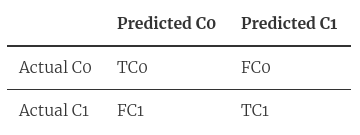

Where:

TCi: True Class i,

FCi: False Class i,

Therefore the precision for any class i:

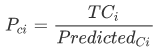

In [ ]:
# Accuracy
acc_task21 = accuracy_from_cm(cm_val_task21)
acc_task31 = accuracy_from_cm(cm_val_task31)
acc_task4 = accuracy_from_cm(cm_val_task4)

#Precision for Class 0
p_c0_task21 = precision_from_cm(cm_val_task21, 0)
p_c0_task31 = precision_from_cm(cm_val_task31, 0)
p_c0_task4 = precision_from_cm(cm_val_task4, 0)

#Precision for Class 1
p_c1_task21 = precision_from_cm(cm_val_task21, 1)
p_c1_task31 = precision_from_cm(cm_val_task31, 1)
p_c1_task4 = precision_from_cm(cm_val_task4, 1)

print("Accuracy @ task21", acc_task21)
print("Accuracy @ task31", acc_task31)
print("Accuracy @ task4", acc_task4)
print('\n')
print("Precision @ Mass task21", p_c0_task21)
print("Precision @ Mass task31", p_c0_task31)
print("Precision @ Mass task4", p_c0_task4)
print('\n')
print("Precision @ Calcification task21", p_c1_task21)
print("Precision @ Calcification task31", p_c1_task31)
print("Precision @ Calcification task4", p_c1_task4)

Accuracy @ task21 0.8796261682242991
Accuracy @ task31 0.9061682242990654
Accuracy @ task4 0.9110280373831776


Precision @ Mass task21 0.8635255889520715
Precision @ Mass task31 0.9305431878895815
Precision @ Mass task4 0.9049586776859504


Precision @ Calcification task21 0.8933518005540165
Precision @ Calcification task31 0.8885309278350515
Precision @ Calcification task4 0.9160409556313993


# Helper Functions

In [ ]:
def compute_save_cm(yt, yp, cm_name):
  # Computes and save cm
  cm = confusion_matrix(yt, yp)
  cm = cm/np.sum(cm)
  np.save(os.path.join(metrics_path, cm_name), np.stack(cm))
  return cm

def plot_confusion_matrix(cm, num_classes, labels, title='Confusion matrix', cmap=plt.cm.Greys):
  # Plots n = len(cm) confusion matrix in nx2 subplot organization
  rows = np.ceil(len(cm)/2)
  cm_idx = 1
  cols = 2

  plt.figure(figsize=(15, rows*6))

  for files in cm:
    if files is not None:
      cm_i = np.load(os.path.join(metrics_path, files))
      plt.subplot(rows, cols, cm_idx)
      plt.imshow(cm_i, interpolation='nearest', cmap=cmap)
      plt.title(files)
      plt.colorbar()
      tick_marks = np.arange(num_classes)
      plt.xticks(tick_marks, labels)
      plt.yticks(tick_marks, labels)
      plt.tight_layout()
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
      print(files)
      print("=>", cm_i, "\n")

      cm_idx += 1

  plt.show() 

def set_binary(y_floating):
  y_binary = np.zeros(y_floating.shape)
  y_binary[aux >= 0.5] = 1
  return y_binary


# Average - AVG
The first approach to merge the previous models' output is to average their output - arithmetic mean.

ACCURACY:  0.8779761904761905
Presion @ Mass: 0.8920454545454545
Presion @ Calcifacion: 0.8625 

scratch21_test_control_cm.npy
=> [[0.5327381 0.       ]
 [0.        0.4672619]] 

task5_avg.npy
=> [[0.4672619  0.06547619]
 [0.05654762 0.41071429]] 



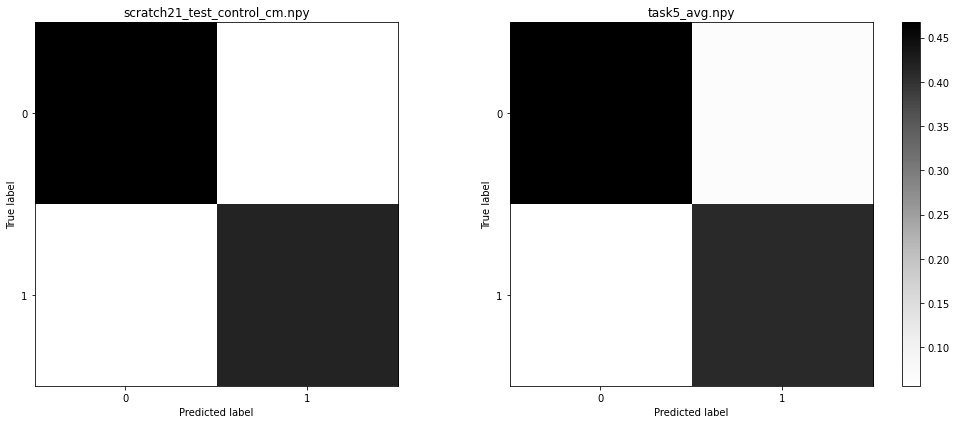

In [ ]:
aux = (y_task21 + y_task31 + y_task4) / 3.0
y_avg = set_binary(aux)
cm_avg = compute_save_cm(y_true, y_avg, "task5_avg.npy")

print("ACCURACY: ", accuracy_score(y_true, y_avg))
print("Presion @ Mass:", precision_from_cm(cm_avg, 0))
print("Presion @ Calcifacion:", precision_from_cm(cm_avg, 1), '\n')

plot_confusion_matrix(("scratch21_test_control_cm.npy", "task5_avg.npy"), 2, [0, 1])

# Weighted Average - WAVG
When performing the arimethic mean, the level of the networks' "confidence"  hasn't been taking into account, it seems like all model perform the same. Based on this reasoning, a weighted average approach is carried out; therefore, predictions coming from high validation accuracy networks have bigger weights. 

ACCURACY:  0.875
Presion @ Mass: 0.887005649717514
Presion @ Calcifacion: 0.8616352201257862 

scratch21_test_control_cm.npy
=> [[0.5327381 0.       ]
 [0.        0.4672619]] 

task5_w_avg.npy
=> [[0.4672619  0.06547619]
 [0.05952381 0.4077381 ]] 



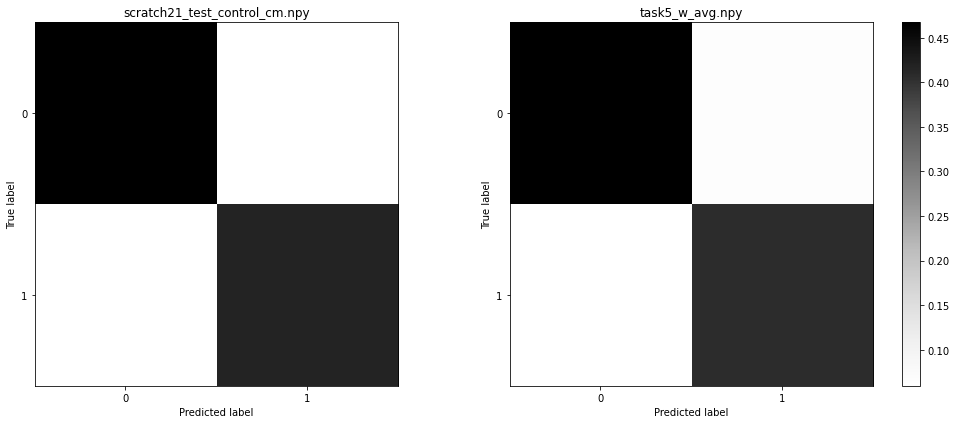

In [ ]:
aux = (y_task21*acc_task21 + y_task31*acc_task31 + y_task4*acc_task4) / (acc_task21 + acc_task31 + acc_task4)
y_w_avg = set_binary(aux)
cm_w_avg = compute_save_cm(y_true, y_w_avg, "task5_w_avg.npy")

print("ACCURACY: ", accuracy_score(y_true, y_w_avg))
print("Presion @ Mass:", precision_from_cm(cm_w_avg, 0))
print("Presion @ Calcifacion:", precision_from_cm(cm_w_avg, 1), '\n')

plot_confusion_matrix(("scratch21_test_control_cm.npy", "task5_w_avg.npy"), 2, [0, 1])

# Logic Voting - LV
So far the entry in to the Ensemble System has been the networks' raw output. Given the fact, we have three networks and the predicted classes in each one should be either 0 or 1, let us threshold the networks' output and then apply Triple modular redundancy method (https://en.wikipedia.org/wiki/Triple_modular_redundancy) or so called, a majority voting.

If two models claim certain input belongs to a certain class, then the opinion of the third model is not taking into account.

In [ ]:
y_task21_01 = np.zeros(y_task21.shape)
y_task31_01 = np.zeros(y_task21.shape)
y_task4_01 = np.zeros(y_task21.shape)

# Thresholding 
y_task21_01[y_task21 >= 0.5] = 1
y_task31_01[y_task31 >= 0.5] = 1
y_task4_01[y_task4 >= 0.5] = 1

ACCURACY:  0.8690476190476191
Presion @ Mass: 0.8813559322033898
Presion @ Calcifacion: 0.8553459119496856 

scratch21_test_control_cm.npy
=> [[0.5327381 0.       ]
 [0.        0.4672619]] 

task5_logic_voting.npy
=> [[0.46428571 0.06845238]
 [0.0625     0.4047619 ]] 



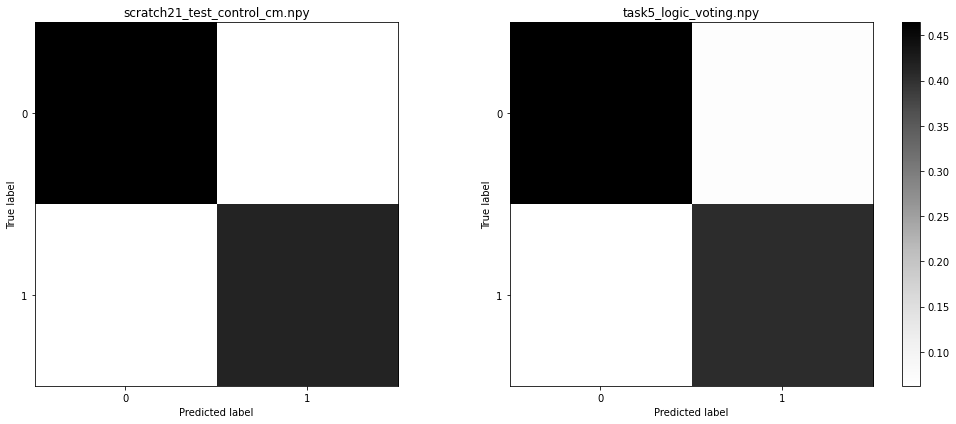

In [ ]:
y_logic_voting = 1 - (1 - y_task21_01*y_task31_01)*(1 - y_task21_01*y_task4_01)*(1 - y_task4_01*y_task31_01)

cm_logic_voting = compute_save_cm(y_true, y_logic_voting, "task5_logic_voting.npy")

print("ACCURACY: ", accuracy_score(y_true, y_logic_voting))
print("Presion @ Mass:", precision_from_cm(cm_logic_voting, 0))
print("Presion @ Calcifacion:", precision_from_cm(cm_logic_voting, 1), '\n')

plot_confusion_matrix(("scratch21_test_control_cm.npy", "task5_logic_voting.npy"), 2, [0, 1])

The approach did not perform as expected and it is the worst one in terms of accuracy and precision per class. This result show it does not matter what majority claims, if they are wrong, they ruined the overall result; hence, it is also important to consider how much uncertainty in their claims are.

# Weighted Average Precision Based - PWAVG
Based in the previous results, the following approach is based on the validation precision per class. 
If a given model claims the input is in certain class, then its output is admitted with a degree of confidence based on how well it did at validation stage (output x precision of the claimed class). All outputs sum and normalized over their respective claimed precisions. 

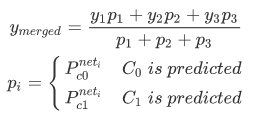

ACCURACY:  0.8630952380952381
Presion @ Mass: 0.8715083798882682
Presion @ Calcifacion: 0.8535031847133758 

scratch21_test_control_cm.npy
=> [[0.5327381 0.       ]
 [0.        0.4672619]] 

task5_pres_w_avg.npy
=> [[0.46428571 0.06845238]
 [0.06845238 0.39880952]] 



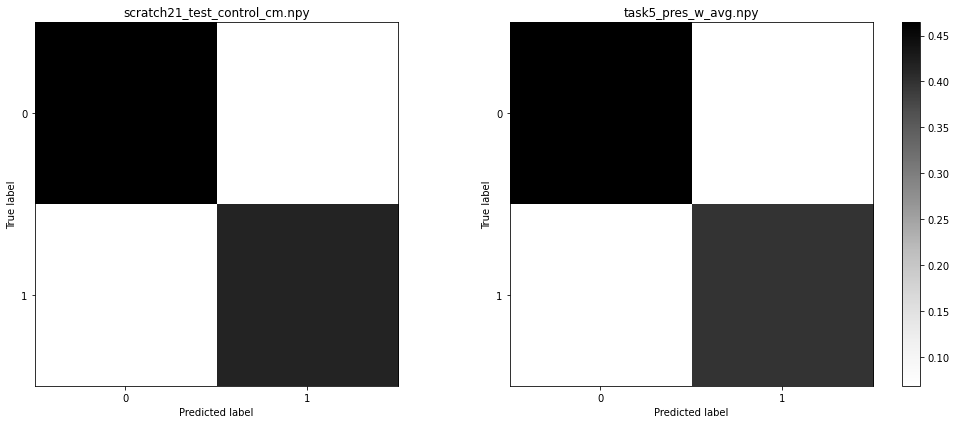

In [ ]:
def precision_accumulator(a, pa):
  if (a >= 0.5):
    return a * pa[1], pa[1]
  else:
    return a * pa[0], pa[0]

def merge_w_prec(a, b, c, pa, pb, pc):
  num_den = precision_accumulator(a, pa)
  num_den += precision_accumulator(b, pb)
  num_den += precision_accumulator(c, pc)
  return num_den[0]/num_den[1]

aux = np.zeros(y_true.shape)

for i in range(y_true.shape[0]):
  aux[i] = merge_w_prec(y_task21[i], y_task31[i], y_task4[i],
                        [p_c0_task21, p_c1_task21], [p_c0_task31, p_c1_task31], 
                        [p_c0_task4, p_c1_task4])

y_pres_w_avg = set_binary(aux)
cm_pres_w_avg = compute_save_cm(y_true, y_pres_w_avg, "task5_pres_w_avg.npy")

print("ACCURACY: ", accuracy_score(y_true, y_pres_w_avg))
print("Presion @ Mass:", precision_from_cm(cm_pres_w_avg, 0))
print("Presion @ Calcifacion:", precision_from_cm(cm_pres_w_avg, 1), '\n')

plot_confusion_matrix(("scratch21_test_control_cm.npy", "task5_pres_w_avg.npy"), 2, [0, 1])

The results are not good as expected, the best merging technique is the simple arithmetic mean of the outputs with 0.878 of accuracy, also showing the best precision per class. The second best is the weighted average reaching 0.875 accuracy. The majority voting system, even it is an interesting approach, it did not perform as good as the simpler method. The precision based method is the worst of them in terms of accuracy and precision per class.

The understanding why the Average method works is written in the report as well as the reasoning about the opinion rating approach.

#Opinion Rating
The involved models' outputs (**model's opinion** O_i = Y_i) around 0.5 have to be meaningless for the merging and outputs close to 0 or 1 have to be kept (or emphasized), so there is a opinion rating. Based on this assumptions, functions such as: sinh, tan, line, cubic, or any odd-degree polynomial around 0.5 can work as Opinion Rating functions, the next step is to  average those opinions. Therefore, the following equations is the resultant of such reasoning.

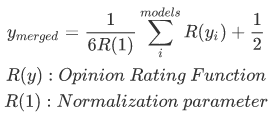

***R*** can be sinh, tan or any odd-degree polynomial. The normalisation parameters ***R(1)*** allows to define how far values around 0.5 will be taking as serious opinions.

Given everything is in terms of probability the final merged value is recentred 0.5 and re-scaled from 0-1.

**The following Opinion Rating Functions will be tested**

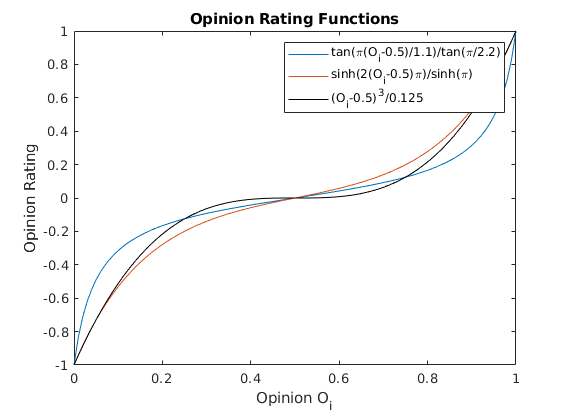

##Tangential Rating

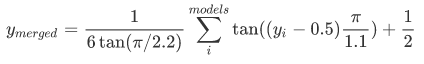

The confusion matrix of this approach shows an increase in the accuracy as well as accuracy per class with respect to AVG method.

ACCURACY:  0.8809523809523809
Presion @ Mass: 0.8926553672316384
Presion @ Calcifacion: 0.8679245283018868 

scratch21_test_control_cm.npy
=> [[0.5327381 0.       ]
 [0.        0.4672619]] 

task5_tan.npy
=> [[0.4702381  0.0625    ]
 [0.05654762 0.41071429]] 



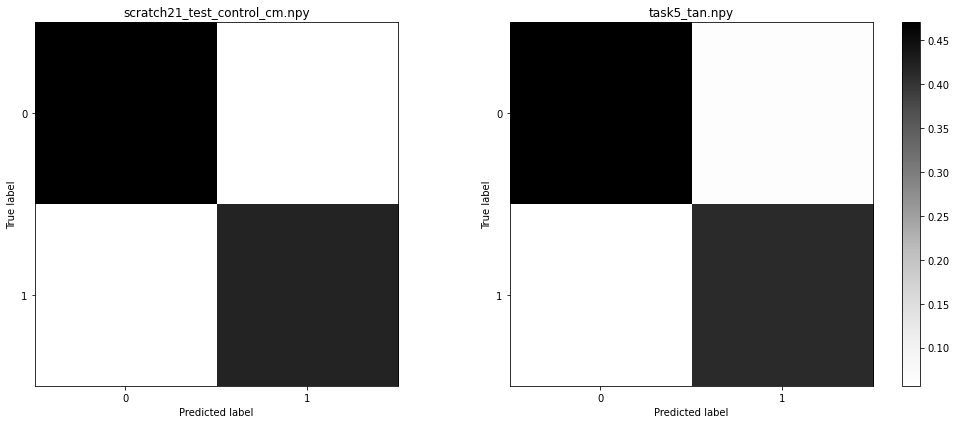

In [ ]:
aux = (np.tan((y_task21 - 0.5)*np.pi/1.1) 
     + np.tan((y_task31 - 0.5)*np.pi/1.1) 
     + np.tan((y_task4 - 0.5)*np.pi/1.1)) / (6.0*np.tan(np.pi/2.2)) + 0.5
y_tan = set_binary(aux)
cm_tan = compute_save_cm(y_true, y_tan, "task5_tan.npy")

print("ACCURACY: ", accuracy_score(y_true, y_tan))
print("Presion @ Mass:", precision_from_cm(cm_tan, 0))
print("Presion @ Calcifacion:", precision_from_cm(cm_tan, 1), '\n')

plot_confusion_matrix(("scratch21_test_control_cm.npy", "task5_tan.npy"), 2, [0, 1])

##Hyperbolic Sine Rating
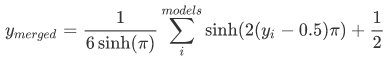

This approach also increases the accuracy with respecto the AVG method and the accuracy per class without increasing the miss-classification. the True Class 1 increases in the same way that False Class 1 decreases. See Confusion Matrix of AVG Method.

ACCURACY:  0.8839285714285714
Presion @ Mass: 0.8977272727272727
Presion @ Calcifacion: 0.86875 

scratch21_test_control_cm.npy
=> [[0.5327381 0.       ]
 [0.        0.4672619]] 

task5_sinh.npy
=> [[0.4702381  0.0625    ]
 [0.05357143 0.41369048]] 



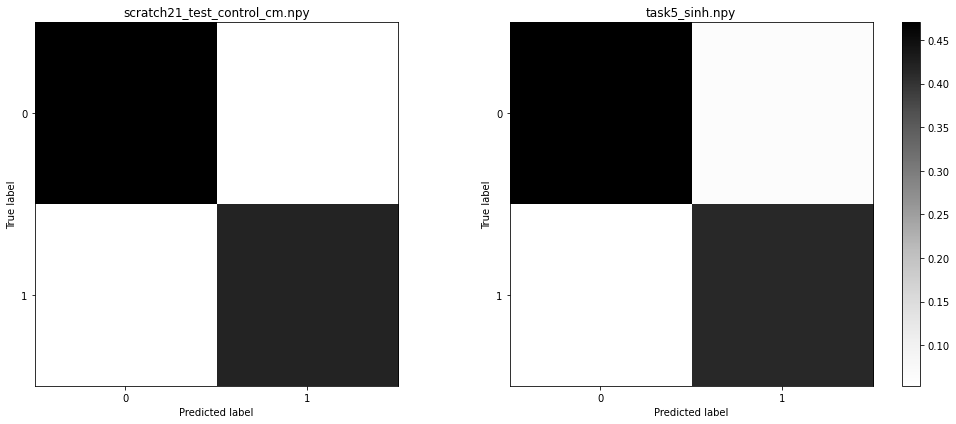

In [ ]:
aux = (np.sinh(2*(y_task21 - 0.5)*np.pi) 
     + np.sinh(2*(y_task31 - 0.5)*np.pi) 
     + np.sinh(2*(y_task4 - 0.5)*np.pi)) / (6.0*np.sinh(np.pi)) + 0.5
y_sinh = set_binary(aux)
cm_sinh = compute_save_cm(y_true, y_sinh, "task5_sinh.npy")

print("ACCURACY: ", accuracy_score(y_true, y_sinh))
print("Presion @ Mass:", precision_from_cm(cm_sinh, 0))
print("Presion @ Calcifacion:", precision_from_cm(cm_sinh, 1), '\n')

plot_confusion_matrix(("scratch21_test_control_cm.npy", "task5_sinh.npy"), 2, [0, 1])

## Polymonial Rating

The following equation is for merging the models' outputs. This approach has the most easy equation to tune and understand, because it only depends on the power ***n***: the higher the value of n, the larger the domain around 0.5 is to be considered meaningless, this model will also help to understand how much of that domain can be devalued.

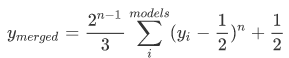

Extra terms around the sum are normalization parameters: re-cetring ( **+ 1/2**) and scaling (**2^(n-1)/3**). 

***n*** wil take 4 values, the following graph shows how this Opinion Rating Function Work: 

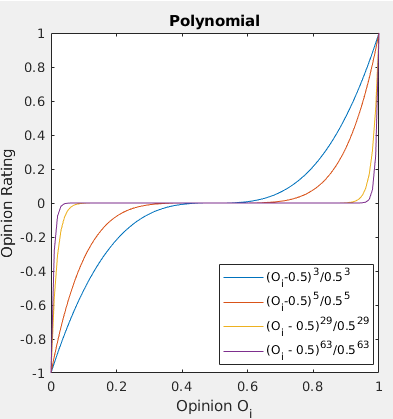

###n = 3
The cubic sum clearly over-passed the Average Method in 0.3% of accuracy, but it is not better than the tangential opinion rating function. 

ACCURACY:  0.8809523809523809
Presion @ Mass: 0.8971428571428571
Presion @ Calcifacion: 0.8633540372670807 

scratch21_test_control_cm.npy
=> [[0.5327381 0.       ]
 [0.        0.4672619]] 

task5_cub.npy
=> [[0.4672619  0.06547619]
 [0.05357143 0.41369048]] 



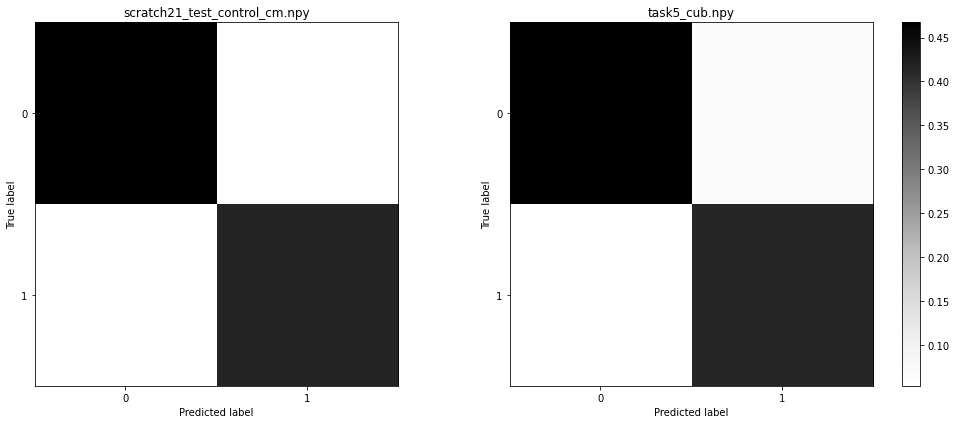

In [ ]:
pown = 3
aux = np.power(2, pown - 1)*(np.power(y_task21-0.5, pown) + np.power(y_task31-0.5, pown) + np.power(y_task4 - 0.5, pown)) / 3.0 + 0.5
y_cub = set_binary(aux)
cm_cub = compute_save_cm(y_true, y_cub, "task5_cub.npy")

print("ACCURACY: ", accuracy_score(y_true, y_cub))
print("Presion @ Mass:", precision_from_cm(cm_cub, 0))
print("Presion @ Calcifacion:", precision_from_cm(cm_cub, 1), '\n')

plot_confusion_matrix(("scratch21_test_control_cm.npy", "task5_cub.npy"), 2, [0, 1])

### n = 5
the accuracy has increased in 0.6%, and the miss-classification per class went down from 6.5% to 6.2% for masses and 5.6% to 5.3% for calcification. Meaning, so far, n = 5 is better than n = 3. Performance similar to Hyperbolic Sine Rating.

ACCURACY:  0.8839285714285714
Presion @ Mass: 0.8977272727272727
Presion @ Calcifacion: 0.86875 

scratch21_test_control_cm.npy
=> [[0.5327381 0.       ]
 [0.        0.4672619]] 

task5_quin.npy
=> [[0.4702381  0.0625    ]
 [0.05357143 0.41369048]] 



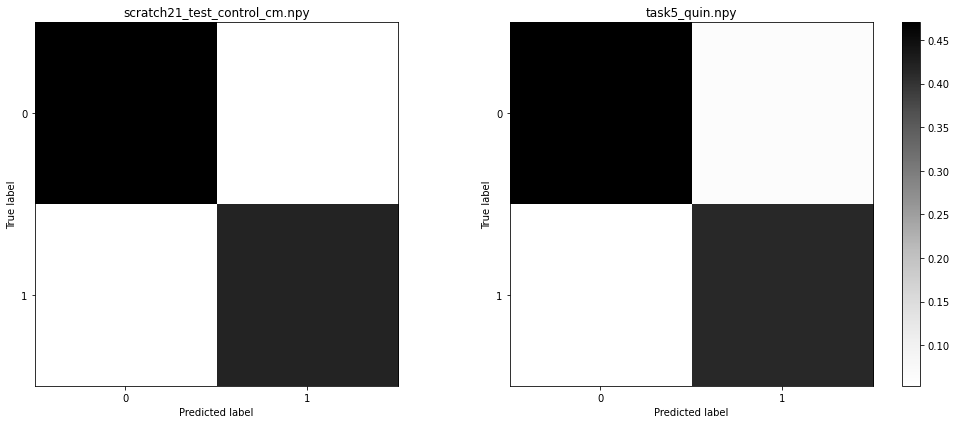

In [ ]:
pown = 5
aux = np.power(2, pown - 1)*(np.power(y_task21-0.5, pown) + np.power(y_task31-0.5, pown) + np.power(y_task4 - 0.5, pown)) / 3.0 + 0.5
y_quin = set_binary(aux)
cm_quin = compute_save_cm(y_true, y_quin, "task5_quin.npy")

print("ACCURACY: ", accuracy_score(y_true, y_quin))
print("Presion @ Mass:", precision_from_cm(cm_quin, 0))
print("Presion @ Calcifacion:", precision_from_cm(cm_quin, 1), '\n')

plot_confusion_matrix(("scratch21_test_control_cm.npy", "task5_quin.npy"), 2, [0, 1])

### n = 29
This experiment with an accuracy of 88.69% means two things:

**First** the higher the value of n, the higher the accuracy.

**Second** Higher accuracy does not involve better classification for classes. From the confusion matrix, it's seen the miss-classification on class 0 has risen to 6.8%, a continuos rising of n will eventually lead to decreament of accuracy due to miss-classification. as seen with n = 63. 

ACCURACY:  0.8869047619047619
Presion @ Mass: 0.912280701754386
Presion @ Calcifacion: 0.8606060606060606 

scratch21_test_control_cm.npy
=> [[0.5327381 0.       ]
 [0.        0.4672619]] 

task5_29.npy
=> [[0.46428571 0.06845238]
 [0.04464286 0.42261905]] 



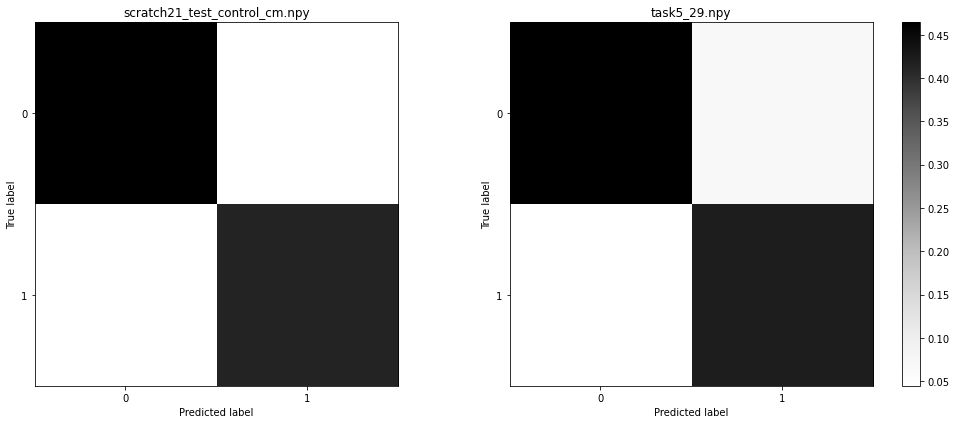

In [ ]:
pown = 29
aux = np.power(2, pown - 1)*(np.power(y_task21 - 0.5, pown) + np.power(y_task31 - 0.5, pown) + np.power(y_task4 - 0.5, pown)) / 3.0 + 0.5
y_29 = set_binary(aux)
cm_29 = compute_save_cm(y_true, y_29, "task5_29.npy")

print("ACCURACY: ", accuracy_score(y_true, y_29))
print("Presion @ Mass:", precision_from_cm(cm_29, 0))
print("Presion @ Calcifacion:", precision_from_cm(cm_29, 1), '\n')

plot_confusion_matrix(("scratch21_test_control_cm.npy", "task5_29.npy"), 2, [0, 1])

### n = 63
n = 63 was taken as maximum because NUMPY reports erros due to small values on the image of the equation.


Too much n drops the accuracy, as well as the input is forced to be classified into class 1. From its confusion matrix, it seems the miss-classification at class 0 is low, but, if the majority is classified into class 1, the error of classifying any input into class 0 obviously decreases.

n is a **hyper parameter** and it has to be carefully chosen based on miss-classifications and overall accuracy. n should be chosen at **validation stage** and not in testing stage, as it is being done in this notebook, the idea was to show a reasoning behind the math of a simple ensemble model.

ACCURACY:  0.8601190476190477
Presion @ Mass: 0.9285714285714286
Presion @ Calcifacion: 0.8021978021978022 

scratch21_test_control_cm.npy
=> [[0.5327381 0.       ]
 [0.        0.4672619]] 

task5_99.npy
=> [[0.42559524 0.10714286]
 [0.0327381  0.43452381]] 



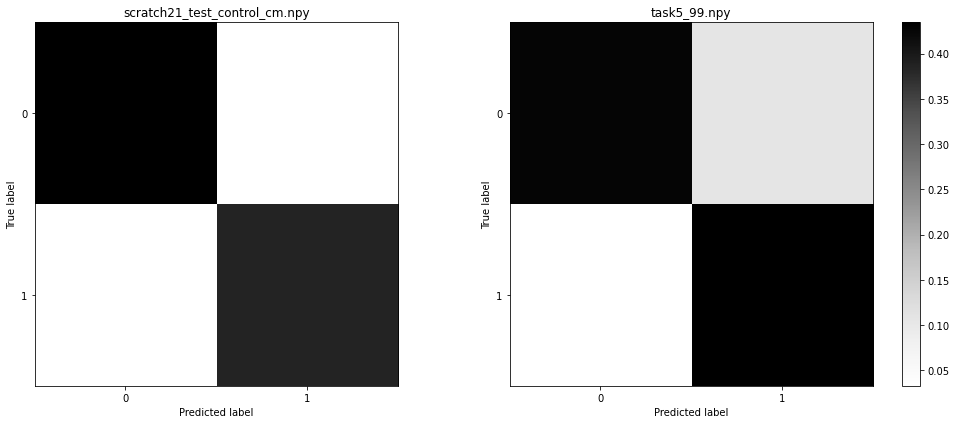

In [ ]:
pown = 63
aux = np.power(2, pown - 1)*(np.power(y_task21-0.5, pown) + np.power(y_task31-0.5, pown) + np.power(y_task4 - 0.5, pown)) / 3.0 + 0.5
y_63 = set_binary(aux)
cm_63 = compute_save_cm(y_true, y_63, "task5_63.npy")

print("ACCURACY: ", accuracy_score(y_true, y_63))
print("Presion @ Mass:", precision_from_cm(cm_63, 0))
print("Presion @ Calcifacion:", precision_from_cm(cm_63, 1), '\n')

plot_confusion_matrix(("scratch21_test_control_cm.npy", "task5_63.npy"), 2, [0, 1])